In [1]:
### Question 1.3.2

# import packages
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.special import expit
from operator import itemgetter

# calculate fixed point conditions
def calc_fp(p, α, δ, x):
    f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
    f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
    return np.array([f1, f2])

# calculate jacobian
def calc_jac(p, α, δ, x):
    j11 = -1
    j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
    j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
    j22 = -1
    return np.array((j11, j12, j21, j22), dtype = float).reshape(2,2)
    

# solve using newton's method
def newton_solver(p, α, δ, x, tol = 1e-14, maxiter = 10000):
    iteration = 1
    diff = 100
    p = p.reshape((2,1))
    while (diff > tol and iteration < maxiter):
        f = calc_fp(p, α, δ, x)
        j = calc_jac(p, α, δ, x)
        p_next = p - np.matmul(np.linalg.inv(j), f)
        diff = np.max(np.abs(p_next - p))
        p = p_next
        iteration += 1
    return p_next.flatten()

# search over grid for multiple equilibria
# thanks to Tanya Rajan for help on the grid search
def find_bne(α, δ, x, sym=False):
    looper = lambda p_guess: newton_solver(p_guess, α, δ, x)
    grid =  np.mgrid[0:1:1e-1, 0:1:1e-1].reshape(2,-1).T
    sols = np.round(np.apply_along_axis(looper, 1, grid),6)
    eqs = np.unique(sols, axis=0)
    if sym == True:
        return eqs[np.argmin(np.abs(eqs[:,0] - eqs[:,1])), :]    
    return eqs

# results
find_bne(1,1,1)
find_bne(1,1,2)
find_bne(3,6,1)
find_bne(3,6,2)

array([[0.71179 , 0.849318],
       [0.784577, 0.784577],
       [0.849318, 0.71179 ]])

In [2]:
### Question 1.3.3

# set up
T = 1000
S = 50
α0 = 3
δ0 = 6

# simulate data
def sim_sample(α,δ,T):
    ε1 = np.random.logistic(0, 1, T*S).reshape(T,S)
    ε2 = np.random.logistic(0, 1, T*S).reshape(T,S)
    x = (np.random.binomial(1,.5, T*S) + 1).reshape(T,S)
    return ε1,ε2,x

ε1_sim,ε2_sim,x_sim = sim_sample(3,6,T)

# probabilities for each x
def find_prob(α, δ, sym=False):
    p1,p2 = find_bne(α, δ, 1, sym=sym),find_bne(α, δ, 2, sym=sym)
    return p1, p2

# symmetric probabilities 
p1_sim, p2_sim = find_prob(3,6,True)
probs_sim = np.zeros((T,S))
probs_sim[x_sim == 1] = p1_sim[0]
probs_sim[x_sim == 2] = p2_sim[0]
print(p1_sim, p2_sim)

# y1, y2
y1_sim = np.zeros((T,S))
y2_sim = np.zeros((T,S))
for s in range(S):
    for t in range(T):
        if (-δ0 * probs_sim[t,s] + α0 * x_sim[t,s] + ε1_sim[t,s]) >= 0:
            y1_sim[t,s] = 1
        else:
            y1_sim[t,s] = 0
        if (-δ0 * probs_sim[t,s] + α0 * x_sim[t,s] + ε2_sim[t,s]) >= 0:
            y2_sim[t,s] = 1
        else:
            y2_sim[t,s] = 0

# log likelihood function
def ll(params, y1, y2, x):
    α = params[0]
    δ = params[1]
    # calculating p for each x value
    probs = np.zeros((x.size))
    p_x1, p_x2 = find_prob(α, δ, True)
    probs[x==1] = p_x1[0]
    probs[x==2] = p_x2[0]
    # likelihood per market
    ll1 = y1*np.log(1/(1+np.exp(δ*probs - α*x))) + (1-y1)*np.log(np.exp(δ*probs - α*x)/(1+np.exp(δ*probs - α*x )))
    ll2 = y2*np.log(1/(1+np.exp(δ*probs - α*x))) + (1-y2)*np.log(np.exp(δ*probs - α*x)/(1+np.exp(δ*probs - α*x )))
    ll = ll1 + ll2  
    return -np.sum(ll)




[0.5 0.5] [0.784577 0.784577]


In [13]:
alphas = np.zeros(S)
deltas = np.zeros(S)
for i in range(S):
    print(i)
    y1s = y1_sim[:,i]
    y2s = y2_sim[:,i]
    xs = x_sim[:,i]
    try:
        x = sp.optimize.minimize(ll, np.array((1,1)), args = (y1s, y2s, xs)).x
    except RuntimeWarning:
        pass
    alphas[i] = x[0]
    deltas[i] = x[1]
    
print(alphas)
print(deltas)

0
1
2
3
4


<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: invalid value encountered in true_divide
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp


5
6


<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp


7
8
9


<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp


10
11
12
13
14
15
16
17
18
19


<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: invalid value encountered in true_divide
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp


20
21


<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp


22
23
24
25
26


<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp


27


<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: invalid value encountered in true_divide
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp


28
29


<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp


30


<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: invalid value encountered in true_divide
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp


31
32
33


<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp


34
35
36
37
38
39
40
41
42
43
44
45


<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: invalid value encountered in true_divide
  j21 = -δ*(np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])))/(1+np.exp(x*α - δ*p[0]))
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp


46
47
48
49


<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:11: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:18: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:12: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-8-0f2df1db37f2>:19: RuntimeWarning: overflow encountered in exp


[2.84981502 2.67660737 2.56416478 4.11690769 3.61581607 3.39683998
 2.76277978 2.40013904 2.9857195  3.14884587 4.17729118 2.71452873
 3.08515195 2.94150341 5.37818373 3.40041998 2.63279006 4.3104816
 5.24399651 3.17936227 2.59562569 5.10435774 1.98653668 2.88626986
 4.06198572 3.03412634 2.65573645 3.67932809 1.80698297 3.6156075
 4.04716272 2.5428477  2.701283   4.93742319 3.09871957 3.42574103
 3.46052479 3.72182152 3.00526792 3.35261452 3.35528229 2.11884896
 2.38578523 2.62148132 2.56332016 2.9594194  2.84483014 3.52431883
 2.94520135 3.87497157]
[ 5.40566191  5.25815507  4.96467399  8.4608548   7.51964292  6.77243519
  5.60085372  4.33958259  5.8729052   6.25793184  8.54426608  5.15597586
  6.12702233  5.90274467 11.61597031  6.88423785  5.02489335  9.15505556
 11.3294614   6.65963229  5.02208906 11.27643045  3.54922707  5.91685756
  8.57398579  6.15113798  5.20105829  7.72219061  3.07762623  7.47189038
  8.4145679   4.68058999  5.15510949 10.57381583  6.10049718  7.39419775
  7.

[2.84981502 2.67660737 2.56416478 4.11690769 3.61581607 3.39683998
 2.76277978 2.40013904 2.9857195  3.14884587 4.17729118 2.71452873
 3.08515195 2.94150341 5.37818373 3.40041998 2.63279006 4.3104816
 5.24399651 3.17936227 2.59562569 5.10435774 1.98653668 2.88626986
 4.06198572 3.03412634 2.65573645 3.67932809 1.80698297 3.6156075
 4.04716272 2.5428477  2.701283   4.93742319 3.09871957 3.42574103
 3.46052479 3.72182152 3.00526792 3.35261452 3.35528229 2.11884896
 2.38578523 2.62148132 2.56332016 2.9594194  2.84483014 3.52431883
 2.94520135 3.87497157]
Mean of α estimates:  3.2498953354848874


[Text(0.5, 1.0, 'α'), Text(0, 0.5, 'Frequency')]

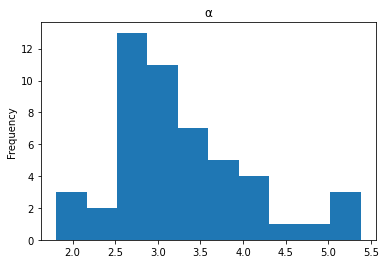

In [15]:
alpha_mean = np.mean(alphas)
print("Mean of α estimates: ", alpha_mean)
plt.hist(alphas, bins = 10)
plt.gca().set(title = 'α', ylabel = 'Frequency')

Mean of delta estimates:  6.572044647618262


[Text(0.5, 1.0, 'delta'), Text(0, 0.5, 'Frequency')]

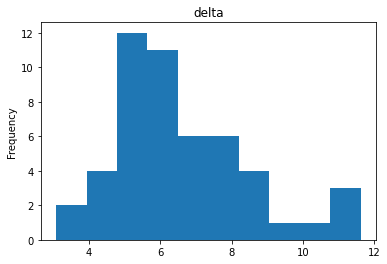

In [17]:
delta_mean = np.mean(deltas)
print("Mean of delta estimates: ", delta_mean)
plt.hist(deltas, bins = 10)
plt.gca().set(title = 'delta', ylabel = 'Frequency')

In [3]:
### Question 1.3.4

## Set up the data generating process
α0 = 3
δ0 = 6
np.random.seed(1234) # for debugging

def find_prob_sorted(α, δ, sym=False):
    p1 = find_bne(α, δ, 1, sym)
    p2 = find_bne(α, δ, 2, sym)
    # we sort by largest probability first
    # by the first column
    first_prob = itemgetter(1)
    p1 = sorted(p1, key = first_prob)
    p2 = sorted(p2, key = first_prob)
    return p1, p2

# simulate the probabilities
p1, p2 = find_prob_sorted(α0, δ0)
p = [p1, p2]
mp1_sim = np.zeros((T,S))
mp2_sim = np.zeros((T,S))
for t in range(T):
    for s in range(S):
        prob = p[x_sim[t,s]-1]
        # set up the probability distribution of choices
        exp_probs = [2, 1, .5]
        eqm_choice_raw = np.divide(np.exp(x_sim[t,s]), exp_probs)
        eqm_choice_probs = eqm_choice_raw/np.sum(eqm_choice_raw)
        # simulate the equilibrium choice
        eqm_choice = np.random.choice(range(len(prob)), 1, p=eqm_choice_probs).item()
        mp1_sim[t,s] = prob[eqm_choice][0]
        mp2_sim[t,s] = prob[eqm_choice][1]


# probability of entry depends on competitor
y1_me = np.zeros((T,S))
y2_me = np.zeros((T,S))
for s in range(S):
    for t in range(T):
        if (-δ0 * mp2_sim[t,s] + α0 * x_sim[t,s] + ε1_sim[t,s]) >= 0:
            y1_me[t,s] = 1
        else:
            y1_me[t,s] = 0
        if (-δ0 * mp1_sim[t,s] + α0 * x_sim[t,s] + ε2_sim[t,s]) >= 0:
            y2_me[t,s] = 1
        else:
            y2_me[t,s] = 0
        

# Set up the multiple equilibria log-likelihood

def ll_me(params, y1, y2, x):
    α = params[0]
    δ = params[1]
    # get p for each type
    p1, p2 = find_prob_sorted(α, δ)
    # numerically adjust the probabilities 
    # to account for different numbers of equilibria
    num_eqm = max(len(p1), len(p2))
    if len(p1) < num_eqm:
        p1 = p1*num_eq
    elif len(p2) < num_eqm:
        p2 = p2*num_eqm 
        
    # set up the log-likelihood 
    ll1 = np.zeros(len(x))
    ll2 = np.zeros(len(x))
    for t in range(len(x)):
        # do a separate likelihood for each type
        # sum over likelihood for each equilibrium
        lleqm1 = np.zeros(num_eqm)
        lleqm2 = np.zeros(num_eqm)
        for eqm in range(num_eqm):
            # weight equilibria depending on xs
            weight = ((eqm+1)/2)*np.exp(-(eqm+1)/(3-x[t]))
            # take simulated probabilities and ys from data
            if x[t]==1:
                pr1 = p1[eqm][0]
                pr2 = p1[eqm][1]
            else:
                pr1 = p2[eqm][0]
                pr2 = p2[eqm][1]
            V1 = δ*pr1 - α*x[t]
            V2 = δ*pr2 - α*x[t]
            lleqm1[eqm] = weight*np.power((1-expit(V1)), (y1[t])) * np.power((expit(V1)), (1-y1[t]))
            lleqm2[eqm] = weight*np.power((1-expit(V2)), (y2[t])) * np.power((expit(V2)), (1-y2[t]))
        ll1[t] = np.log(np.sum(lleqm1))
        ll2[t] = np.log(np.sum(lleqm2))
    # sum over both x = 1 and x = 2 log likelihoods
    ll = ll1+ll2
    return -np.sum(ll)


params0 = np.array((1,1))
practice_ll = ll_me(params0, y1_me[:,1], y2_me[:,1], x_sim[:,1])
print(practice_ll)
#first_pass = sp.optimize.minimize(ll_me, params0 ,args=(y1_me[:,1], y2_me[:,1], x_sim[:,1])).x
#print(first_pass)
    

4113.097272149282


In [4]:
# solve for distribution of multiple equilibria log-likelihood
S=10 #because this is taking too long to run
alphas_me = np.zeros(S)
deltas_me = np.zeros(S)
for i in range(S):
    print(i)
    y1s = y1_me[:,i]
    y2s = y2_me[:,i]
    xs = x_sim[:,i]
    try:
        x = sp.optimize.minimize(ll_me, np.array((1,1)), args = (y1s, y2s, xs)).x
    except RuntimeWarning:
        pass
    alphas_me[i] = x[0]
    deltas_me[i] = x[1]
    
print(alphas_me)
print(deltas_me)

0
1
2
3
4
5
6
7
8
9


<ipython-input-1-bb954b9fa096>:13: RuntimeWarning: overflow encountered in exp
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-1-bb954b9fa096>:13: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])) - p[0]
<ipython-input-1-bb954b9fa096>:20: RuntimeWarning: overflow encountered in exp
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-1-bb954b9fa096>:20: RuntimeWarning: invalid value encountered in true_divide
  j12 = -δ*(np.exp(x*α - δ*p[1])/(1+np.exp(x*α - δ*p[1])))/(1+np.exp(x*α - δ*p[1]))
<ipython-input-1-bb954b9fa096>:14: RuntimeWarning: overflow encountered in exp
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-1-bb954b9fa096>:14: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(x*α - δ*p[0])/(1+np.exp(x*α - δ*p[0])) - p[1]
<ipython-input-1-bb954b9fa096>:21: RuntimeWarning: overflow encountered in exp


[2.07072935 2.28467086 2.19541272 2.23577111 2.34476552 2.01963629
 2.41456499 2.25701419 2.20133131 2.36223009]


NameError: name 'deltas' is not defined

In [ ]:
print(deltas_me)

Mean of α estimates:  2.2386126440803773


[Text(0.5, 1.0, 'α'), Text(0, 0.5, 'Frequency')]

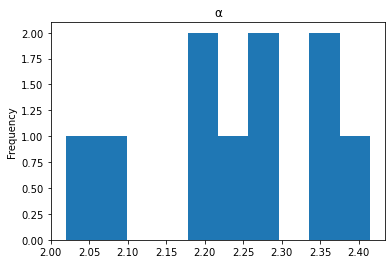

In [7]:
alpha_mean = np.mean(alphas_me)
print("Mean of α estimates: ", alpha_mean)
plt.hist(alphas_me, bins = 10)
plt.gca().set(title = 'α', ylabel = 'Frequency')

Mean of delta estimates:  4.269690330787646


[Text(0.5, 1.0, 'delta'), Text(0, 0.5, 'Frequency')]

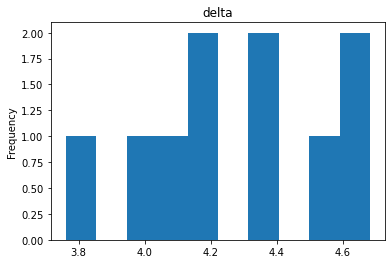

In [8]:
delta_mean = np.mean(deltas_me)
print("Mean of delta estimates: ", delta_mean)
plt.hist(deltas_me, bins = 10)
plt.gca().set(title = 'delta', ylabel = 'Frequency')